## Func

In [ ]:
from argparse import Namespace
import os
import json

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#### preproc

In [ ]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token
                              for token, idx in self._token_to_idx.items()}


    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index

    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary

        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token

        Args:
            token (str): the token to look up
        Returns:
            index (int): the index corresponding to the token
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index

        Args:
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [ ]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def lookup_token(self, token):
        """Retrieve the index associated with the token
          or the UNK index if token isn't present.

        Args:
            token (str): the token to look up
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary)
              for the UNK functionality
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

In [ ]:
class SurnameVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, char_vocab, nationality_vocab):
        """
        Args:
            char_vocab (Vocabulary): maps characters to integers
            nationality_vocab (Vocabulary): maps nationalities to integers
        """
        self.char_vocab = char_vocab
        self.nationality_vocab = nationality_vocab

    def vectorize(self, surname, vector_length=-1):
        """
        Args:
            title (str): the string of characters
            vector_length (int): an argument for forcing the length of index vector
        """
        indices = [self.char_vocab.begin_seq_index]
        indices.extend(self.char_vocab.lookup_token(token)
                       for token in surname)
        indices.append(self.char_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.char_vocab.mask_index

        return out_vector, len(indices)

    @classmethod
    def from_dataframe(cls, surname_df):
        """Instantiate the vectorizer from the dataset dataframe

        Args:
            surname_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the SurnameVectorizer
        """
        char_vocab = SequenceVocabulary()
        nationality_vocab = Vocabulary()

        for index, row in surname_df.iterrows():
            for char in row.surname:
                char_vocab.add_token(char)
            nationality_vocab.add_token(row.nationality)

        return cls(char_vocab, nationality_vocab)

In [ ]:
class SurnameDataset(Dataset):
    def __init__(self, surname_df, vectorizer):
        """
        Args:
            surname_df (pandas.DataFrame): the dataset
            vectorizer (SurnameVectorizer): vectorizer instatiated from dataset
        """
        self.surname_df = surname_df
        self._vectorizer = vectorizer

        self._max_seq_length = max(map(len, self.surname_df.surname)) + 2

        self.train_df = self.surname_df[self.surname_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.surname_df[self.surname_df.split=='val']
        self.validation_size = len(self.val_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size)}

        self.set_split('train')

        # Class weights
        class_counts = self.train_df.nationality.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)


    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv):
        """Load dataset and make a new vectorizer from scratch

        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        train_surname_df = surname_df[surname_df.split=='train']
        return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df))


    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets

        Args:
            index (int): the index to the data point
        Returns:
            a dictionary holding the data point's:
                features (x_data)
                label (y_target)
                feature length (x_length)
        """
        row = self._target_df.iloc[index]

        surname_vector, vec_length = \
            self._vectorizer.vectorize(row.surname, self._max_seq_length)

        nationality_index = \
            self._vectorizer.nationality_vocab.lookup_token(row.nationality)

        return {'x_data': surname_vector,
                'y_target': nationality_index,
                'x_length': vec_length}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size



def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

### model

In [ ]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

### sets

In [ ]:
args = Namespace(
    # Data and path information
    surname_csv="surnames_with_splits.csv",
    # Model hyper parameter
    char_embedding_size=100,
    rnn_hidden_size=64,
    # Training hyper parameter
    num_epochs=25,
    learning_rate=1e-3,
    batch_size=64,
    seed=1337,
    # Runtime hyper parameter
    cuda=True,
    catch_keyboard_interrupt=True,
)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")

print("Using CUDA: {}".format(args.cuda))


# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

Using CUDA: False


In [ ]:
def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [ ]:
def predict_nationality(surname, classifier, vectorizer):
    vectorized_surname, vec_length = vectorizer.vectorize(surname)
    vectorized_surname = torch.tensor(vectorized_surname).unsqueeze(dim=0)
    vec_length = torch.tensor([vec_length], dtype=torch.int64)

    result = classifier(vectorized_surname, vec_length, apply_softmax=True)
    probability_values, indices = result.max(dim=1)

    index = indices.item()
    prob_value = probability_values.item()

    predicted_nationality = vectorizer.nationality_vocab.lookup_index(index)

    return f"{surname} - {predicted_nationality} ({round(prob_value, 2)})"

# Лабораторная №4. Обучение рекурентной нейронной сети

Скачайте датасет с фамилиями разных национальностей, используемый на практическом занятии. Необходимо обучить несколько рекурентных нейронных сетей для классификации фамилий по национальностям. Нейтронные сети должны отличаться гиперпараметрами.

### 1. Проведите два эксперимента-исследования при изменении гиперпараметров, cформулируйте выводы:



*   Измените архитектуру нейронной сети (например, RNN, LSTM, GRU и т.д.),
```
self.rnn = nn.RNN(input_size=embedding_size,
                  hidden_size=rnn_hidden_size,
                  batch_first=batch_first)
```

изменено на LSTM

In [ ]:
def column_gather(y_out, x_lengths):
    '''Get a specific vector from each batch datapoint in `y_out`.

    More precisely, iterate over batch row indices, get the vector that's at
    the position indicated by the corresponding value in `x_lengths` at the row
    index.

    Args:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, sequence, feature)
        x_lengths (torch.LongTensor, torch.cuda.LongTensor)
            shape: (batch,)

    Returns:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, feature)
    '''
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1

    out = []
    for batch_index, column_index in enumerate(x_lengths):
        out.append(y_out[batch_index, column_index])

    return torch.stack(out)


class SurnameClassifier(nn.Module):
    """ A Classifier with an RNN to extract features and an MLP to classify """
    def __init__(self, embedding_size, num_embeddings, num_classes,
                 rnn_hidden_size, batch_first=True, padding_idx=0):
        """
        Args:
            embedding_size (int): The size of the character embeddings
            num_embeddings (int): The number of characters to embed
            num_classes (int): The size of the prediction vector
                Note: the number of nationalities
            rnn_hidden_size (int): The size of the RNN's hidden state
            batch_first (bool): Informs whether the input tensors will
                have batch or the sequence on the 0th dimension
            padding_idx (int): The index for the tensor padding;
                see torch.nn.Embedding
        """
        super(SurnameClassifier, self).__init__()

        self.emb = nn.Embedding(num_embeddings=num_embeddings,
                                embedding_dim=embedding_size,
                                padding_idx=padding_idx)
        self.lstm = nn.LSTM(input_size=embedding_size,
                            hidden_size=rnn_hidden_size,
                            batch_first=batch_first)
        self.fc1 = nn.Linear(in_features=rnn_hidden_size,
                         out_features=rnn_hidden_size)
        self.fc2 = nn.Linear(in_features=rnn_hidden_size,
                          out_features=num_classes)

    def forward(self, x_in, x_lengths=None, apply_softmax=False):
        """The forward pass of the classifier

        Args:
            x_in (torch.Tensor): an input data tensor.
                x_in.shape should be (batch, input_dim)
            x_lengths (torch.Tensor): the lengths of each sequence in the batch.
                They are used to find the final vector of each sequence
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        x_embedded = self.emb(x_in)
        y_out, _ = self.lstm(x_embedded)

        if x_lengths is not None:
            y_out = column_gather(y_out, x_lengths)
        else:
            y_out = y_out[:, -1, :]

        y_out = F.relu(self.fc1(y_out))
        y_out = self.fc2(y_out)
        # y_out = F.relu(self.fc1(F.dropout(y_out, 0.5)))
        # y_out = self.fc2(F.dropout(y_out, 0.5))

        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)

        return y_out


dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
vectorizer = dataset.get_vectorizer()
classifier = SurnameClassifier(embedding_size=args.char_embedding_size,
                               num_embeddings=len(vectorizer.char_vocab),
                               num_classes=len(vectorizer.nationality_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = {'learning_rate': args.learning_rate,
               'epoch_index': 0,
               'train_loss': [],
               'train_acc': [],
               'val_loss': [],
               'val_acc': []}

for epoch_index in tqdm(range(args.num_epochs)):
    train_state['epoch_index'] = epoch_index

    dataset.set_split('train')
    batch_generator = generate_batches(dataset,
                                        batch_size=args.batch_size,
                                        device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.train()

    for batch_index, batch_dict in enumerate(batch_generator):
        optimizer.zero_grad()
        y_pred = classifier(x_in=batch_dict['x_data'],
                            x_lengths=batch_dict['x_length'])

        loss = loss_func(y_pred, batch_dict['y_target'])

        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        loss.backward()

        optimizer.step()
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)

    dataset.set_split('val')
    batch_generator = generate_batches(dataset,
                                       batch_size=args.batch_size,
                                       device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        y_pred = classifier(x_in=batch_dict['x_data'],
                            x_lengths=batch_dict['x_length'])

        loss = loss_func(y_pred, batch_dict['y_target'])
        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)

    scheduler.step(train_state['val_loss'][-1])

  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
classifier = classifier.to("cpu")
for surname in ['McMahan', 'Nakamoto', 'Wan', 'Cho', 'Opletin', 'Opletina']:
    print(predict_nationality(surname, classifier, vectorizer))

McMahan - Irish (0.99)
Nakamoto - Japanese (0.99)
Wan - Chinese (0.91)
Cho - Korean (0.92)
Opletin - Russian (0.56)
Opletina - Spanish (0.67)


точность на тестовых - больше 70%, на валидации - больше 60%

функция потерь на тестовых ~0.6, на валидации ~1.6



*   Измените гиперпараметры для выбранной архитектуры сети (например, embedding_size, rnn_hidden_size и др).

In [ ]:
args = Namespace(
    # Data and path information
    surname_csv="surnames_with_splits.csv",
    # Model hyper parameter
    char_embedding_size=120,
    rnn_hidden_size=30,
    # Training hyper parameter
    num_epochs=30,
    learning_rate=1e-3,
    batch_size=64,
    seed=1337,
    # Runtime hyper parameter
    cuda=True,
    catch_keyboard_interrupt=True,
)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")

print("Using CUDA: {}".format(args.cuda))


# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

Using CUDA: False


In [ ]:
dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
vectorizer = dataset.get_vectorizer()
classifier = SurnameClassifier(embedding_size=args.char_embedding_size,
                               num_embeddings=len(vectorizer.char_vocab),
                               num_classes=len(vectorizer.nationality_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = {'learning_rate': args.learning_rate,
               'epoch_index': 0,
               'train_loss': [],
               'train_acc': [],
               'val_loss': [],
               'val_acc': []}

for epoch_index in tqdm(range(args.num_epochs)):
    train_state['epoch_index'] = epoch_index

    dataset.set_split('train')
    batch_generator = generate_batches(dataset,
                                        batch_size=args.batch_size,
                                        device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.train()

    for batch_index, batch_dict in enumerate(batch_generator):
        optimizer.zero_grad()
        y_pred = classifier(x_in=batch_dict['x_data'],
                            x_lengths=batch_dict['x_length'])

        loss = loss_func(y_pred, batch_dict['y_target'])

        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        loss.backward()

        optimizer.step()
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)

    dataset.set_split('val')
    batch_generator = generate_batches(dataset,
                                       batch_size=args.batch_size,
                                       device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        y_pred = classifier(x_in=batch_dict['x_data'],
                            x_lengths=batch_dict['x_length'])

        loss = loss_func(y_pred, batch_dict['y_target'])
        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)

    scheduler.step(train_state['val_loss'][-1])

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
classifier = classifier.to("cpu")
for surname in ['McMahan', 'Nakamoto', 'Wan', 'Cho', 'Opletin', 'Opletina']:
    print(predict_nationality(surname, classifier, vectorizer))

McMahan - Irish (0.95)
Nakamoto - Japanese (0.97)
Wan - Chinese (0.86)
Cho - Korean (0.77)
Opletin - Russian (0.4)
Opletina - Spanish (0.57)


При изменении гиперпараметров вероятность отнесения той или иной фамилии к национальности стала меньше.

### 2. Выберите один из наборов гиперпараметров и проиллюстрируйте зависимость качества классификации от количества эпох обучения. Можно ли выделить эпохи, где модель недообучилась/переобучилась?

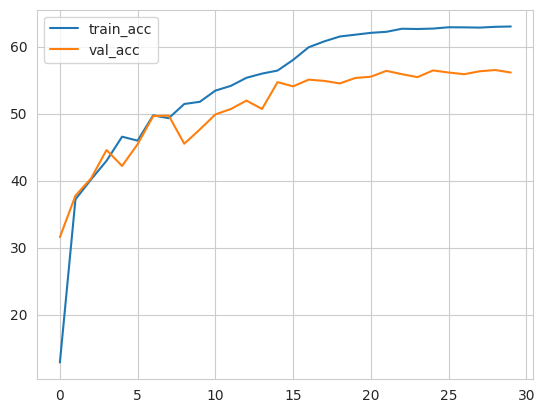

In [ ]:
acc_labels = ["train_acc", "val_acc"]

for label in acc_labels:
    y = train_state[label]
    plt.plot(y, label=label)

plt.legend()

Ближе к 10 эпохе (примерно 8 эпоха) идет понижение точности на валидационной выборке, но рост точности на тренировочной, что говорит о переобучении модели. То же самое можно сказать о 4 эпохе и 13, где видно явное переобучение

### 3. левые метки в датасете не сбалансированы. Для учета весов классов в функцию потерь CrossEntropyLoss передают аргумент с соответствующими весами. Как изменились потери/точность при обучении при наличии/отсутствии аргумента с весами классов? Чем можно объяснить данные изменения?


```
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
```



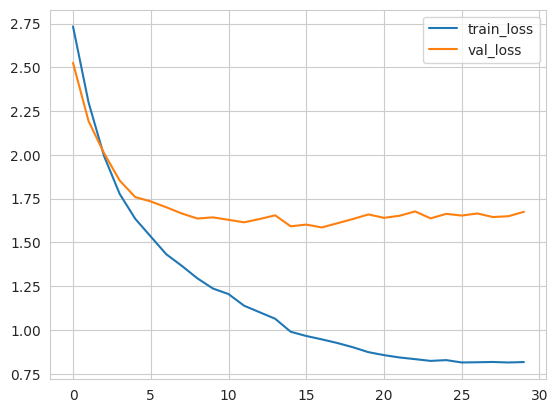

In [ ]:
# до изменения функции потерь
loss_labels = ["train_loss", "val_loss"]

for label in loss_labels:
    y = train_state[label]
    plt.plot(y, label=label)

plt.legend()

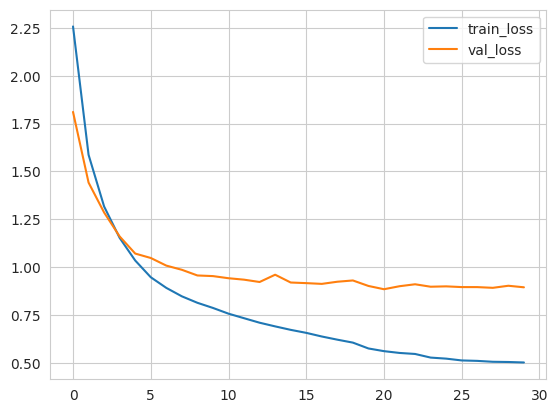

In [ ]:
# после изменения функции потерь
loss_labels = ["train_loss", "val_loss"]

for label in loss_labels:
    y = train_state[label]
    plt.plot(y, label=label)

plt.legend()

До измненения функции потерь, можно увидеть переобучение модели, так как график валидационной выборки немного увеличился, в то время как тренировочный уменьшается

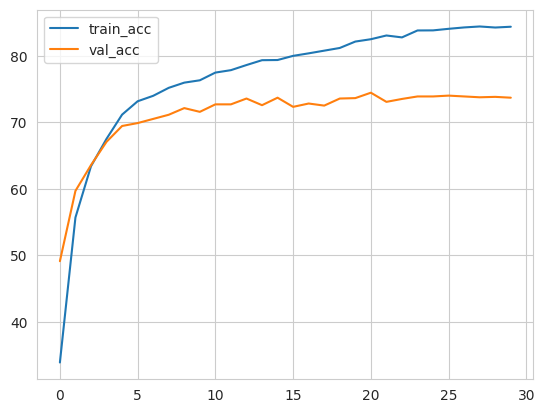

In [ ]:
acc_labels = ["train_acc", "val_acc"]

for label in acc_labels:
    y = train_state[label]
    plt.plot(y, label=label)

plt.legend()

Заметно, что точность модели упала. Скорее всего, это связано с тем, что модель, ввиду отсутствия весов, склонна предсказывать более представленные классы

### 4. Какие национальности определяются лучше всего? С чем это может быть связано? Можно ли выделить группы национальностей в которых алгоритм путается больше всего? С чем это может быть связано? Визуализируйте результаты (например, с использованием confusion matrix).

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [ ]:
data = pd.read_csv('/content/surnames_with_splits.csv')
data

,surname,nationality,split
0,Totah,Arabic,train
1,Abboud,Arabic,train
2,Fakhoury,Arabic,train
3,Srour,Arabic,train
4,Sayegh,Arabic,train
...,...,...,...
10975,Dinh,Vietnamese,test
10976,Phung,Vietnamese,test
10977,Quang,Vietnamese,test
10978,Vu,Vietnamese,test


In [ ]:
X_train = data[data['split'] == 'train']['surname']
y_train = data[data['split'] == 'train']['nationality']
X_test = data[data['split'] == 'test']['surname']
y_test = data[data['split'] == 'test']['nationality']

vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

clf = MultinomialNB()
clf.fit(X_train_vec, y_train)

y_pred = clf.predict(X_test_vec)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Arabic       0.99      1.00      1.00       241
     Chinese       0.00      0.00      0.00        33
       Czech       0.00      0.00      0.00        63
       Dutch       0.00      0.00      0.00        36
     English       0.32      0.99      0.48       447
      French       0.00      0.00      0.00        35
      German       0.00      0.00      0.00        87
       Greek       0.00      0.00      0.00        24
       Irish       0.00      0.00      0.00        28
     Italian       0.40      0.02      0.04        90
    Japanese       0.00      0.00      0.00       117
      Korean       0.00      0.00      0.00        13
      Polish       0.00      0.00      0.00        18
  Portuguese       0.00      0.00      0.00         9
     Russian       0.73      0.02      0.04       357
    Scottish       0.00      0.00      0.00        12
     Spanish       0.00      0.00      0.00        40
  Vietnamese       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


судя по получившейся таблице, лучше всего определяются арабские фамили и английские (метрика recall). Возможно, это связано с тем, что их содержится болше всего в датасете. Однако можно заметить, что руссих фамилий больше, чем арабских, которых модель праивльно определяет. Во время экспериментов (п.1) было показано, что если брать русскую фамилию в мужском роде, то модель классифицирует ее верно. В ж.р. уже появляются проблемы из-за окончаний

Для проверки посмотрим представленность каждой фамилии в датасете:

In [ ]:
data['nationality'].value_counts()

English       2972
Russian       2373
Arabic        1603
Japanese       775
Italian        600
German         576
Czech          414
Spanish        258
Dutch          236
French         229
Chinese        220
Irish          183
Greek          156
Polish         120
Korean          77
Scottish        75
Vietnamese      58
Portuguese      55
Name: nationality, dtype: int64

как видно из таблицы выше, больше всего датасет действительно содержит русских, английских и арабских фамилий